## Projet NLP: Sentiment analysis

L’objectif de notre projet est de réaliser une analyse sentimentale et visuelle des commentaires politiques présents dans notre jeu de données, du fameux site marocain Hespress. Dans un second temps, le but sera de parvenir à classifier les sentiments de ces commentaires selon qu’ils soient plutôt positifs, neutres ou négatifs à l'aide des différents modèles disponibles en Python.  

### Etape 1: Library import and data exploration

In [10]:
import numpy as np
import pandas as pd
import nltk
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from sklearn import svm
from sklearn.svm import SVC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV



Tout d’abord, voici un premier aperçu du jeu de données que nous avons à disposition : télécharger le jeu de donnée, obtenu à l’aide de la commande data.head(). 

In [2]:
data = pd.read_csv('comments.csv', sep=',', encoding='utf-8')
data.head()

,comment,score
0,فليجتمعوا لما فيه خير ليبيا و ينهو هذا الصراع ...,69
1,ايوى الرؤساء لن يحضروا يعني هناك ضغوط خارجية و...,-18
2,ا لامبراطورية المغربية العظمى لها تاريخ وشعب ع...,29
3,الحل الوحيد هو تقسيم ليبيا الي الشرق والغرب هذ...,-87
4,نتمنى لاخوة اللبيين ان يتوافقوا و يتفقوا على م...,27


In [3]:
data.shape

(45857, 2)

Comme nous pouvons l’apercevoir, ce jeu de données recensant au total 45857 de commentaires, contient deux colonnes intitulées comment et score.

### ***Etape 2:*** Text pre-processing

#### **1-** remove punctuations
#### **2-** remove diacritics
#### **3-** remove mentions
#### **4-** allow_only_ar
#### **5-** remove longation
#### **6-** remove stopwords

In [4]:
#list of arabic and english punctiations 

punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

# Arabic stop words with nltk
stop_words = stopwords.words()

arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def preprocess(text):
    
    #remove punctuations
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)
    
    # remove diacritics
    text = re.sub(arabic_diacritics, '', text)
    
    #remove_mention
    text = re.sub(r'@\S+', '', text)
    
    #allow_only_ar
    text = re.sub(r'[^\u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD]+', ' ', text)

    #remove longation
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    
    #remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    

    return text
  
data['comment'] = data['comment'].apply(preprocess)
print(data.head(5))

                                             comment  score
0  فليجتمعوا خير ليبيا و ينهو الصراع عمر طويلا و ...     69
1  ايوي الرءساء يحضروا يعني ضغوط خارجيه والجوله س...    -18
2  ا لامبراطوريه المغربيه العظمي تاريخ وشعب عريق ...     29
3  الحل الوحيد تقسيم ليبيا الي الشرق والغرب الحل ...    -87
4  نتمني لاخوه اللبيين ان يتوافقوا و يتفقوا علي خ...     27


### ***Etape 3:*** Drawing a WordCloud

Voici un nuage de mots dans lequel on peut apercevoir quels sont les mots les plus utilisés dans les commentaires des utilisateurs (plus la taille de la police d’un mot est grande, plus le nombre d’occurrences de celui-ci est important)

(-0.5, 399.5, 199.5, -0.5)

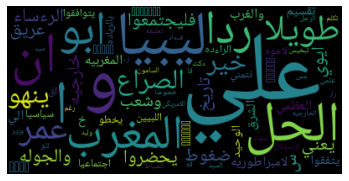

In [5]:
import os
import codecs
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

 
text_data = str(data['comment'])


# Make text readable for a non-Arabic library like wordcloud
text = arabic_reshaper.reshape(text_data)
text = get_display(text)

# Generate a word cloud image
wordcloud = WordCloud(font_path='NotoNaskhArabic-Regular.ttf').generate(text)

# Export to an image
img = wordcloud.to_file("arabic_example.png")
plt.imshow(img, interpolation='bilinear')
plt.axis("off")

### Sentiment Analysis with different techniques

In [6]:
#using score column
def getAnalysis(score):
    if score>=0:
        return 'positive'
    elif score<0:
        return 'negative'
  

data['Analysis'] = data['score'].apply(getAnalysis)
data

,comment,score,Analysis
0,فليجتمعوا خير ليبيا و ينهو الصراع عمر طويلا و ...,69,positive
1,ايوي الرءساء يحضروا يعني ضغوط خارجيه والجوله س...,-18,negative
2,ا لامبراطوريه المغربيه العظمي تاريخ وشعب عريق ...,29,positive
3,الحل الوحيد تقسيم ليبيا الي الشرق والغرب الحل ...,-87,negative
4,نتمني لاخوه اللبيين ان يتوافقوا و يتفقوا علي خ...,27,positive
...,...,...,...
45852,المغرب يخطو بالرياده الراءده سياسيا اجتماعيا ا...,-4,negative
45853,وزير الخارجيه الامريكي زار المغرب الاستقلال اق...,3,positive
45854,انا ارد علي سيد ابو وليد تعليقه خصوصا تبخيس مس...,3,positive
45855,ردا علي السيد فءاد تكلم علي الضباط السامون للق...,3,positive


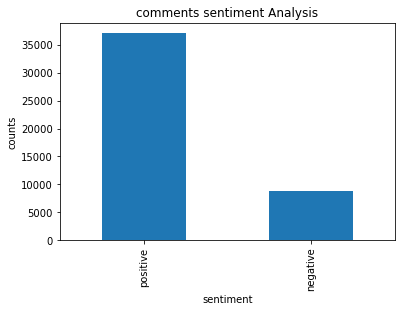

In [7]:
data['Analysis'].value_counts()

plt.title('comments sentiment Analysis')
plt.xlabel('sentiment')
plt.ylabel('counts')
data['Analysis'].value_counts().plot(kind='bar')
plt.show()

### Multinomial Naïve Bayes (MNB)	
Based on word appearance only.
Can account for multiple repetitions of a word.
Faster than plain NB.


In [5]:
X = CountVectorizer(analyzer = preprocess, dtype="uint8").fit_transform(data["comment"]).toarray()
y = data["score"].apply(lambda x: 'positive' if x >= 0 else 'negative')


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.023)

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train,y_train)

MultinomialNB()

              precision    recall  f1-score   support

    negative       0.33      0.02      0.04       170
    positive       0.84      0.99      0.91       885

    accuracy                           0.84      1055
   macro avg       0.59      0.51      0.48      1055
weighted avg       0.76      0.84      0.77      1055



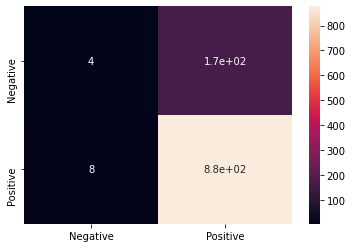

In [6]:
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test,y_predict_test)
sns.heatmap(cm, annot=True, xticklabels = ['Negative', 'Positive'],yticklabels=['Negative','Positive'])
print(classification_report(y_test,y_predict_test))


### Support Vector Machine (SVM)

SVC accuracy_score 83.88625592417061


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       170
    positive       0.84      1.00      0.91       885

    accuracy                           0.84      1055
   macro avg       0.42      0.50      0.46      1055
weighted avg       0.70      0.84      0.77      1055



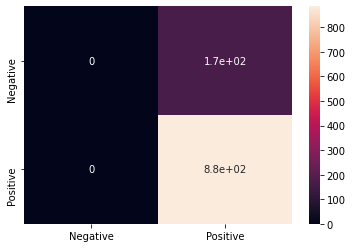

In [11]:
#SVC
clf = svm.SVC()
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
print("SVC accuracy_score",accuracy_score(y_test, pred)*100)

cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True, xticklabels = ['Negative', 'Positive'],yticklabels=['Negative','Positive'])

print(classification_report(y_test,pred))

### Logistic Regression 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

LogisticRegression accuracy_score 83.88625592417061
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       170
    positive       0.84      1.00      0.91       885

    accuracy                           0.84      1055
   macro avg       0.42      0.50      0.46      1055
weighted avg       0.70      0.84      0.77      1055



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


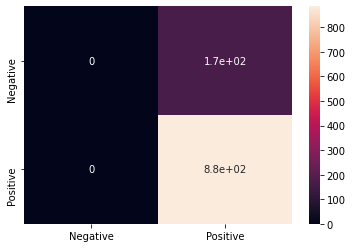

In [13]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
pred=logisticRegr.predict(X_test)
print("LogisticRegression accuracy_score",accuracy_score(y_test, pred)*100)

cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True, xticklabels = ['Negative', 'Positive'],yticklabels=['Negative','Positive'])

print(classification_report(y_test,pred))